In [9]:

import numpy as np
import pickle
from matplotlib import pyplot as plt
from nltk.tokenize import TreebankWordTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split

In [2]:
reviews = np.load('data/reviews.npz')
X_train, y_train = reviews['X'], reviews['y']
X_train.shape, y_train.shape

((687289, 1093), (687289,))

In [3]:
with open('data/word2idx.pkl', 'rb') as f:
    word2idx = pickle.load(f)
word2idx

{'ysister': 1,
 'high-end/fine': 2,
 'if-i-eat-another-bite-i-might-throw-up': 3,
 'ounter': 4,
 'chey': 5,
 'methodical': 6,
 'salad-nut': 7,
 'comfirm': 8,
 'drawings/calligraphy': 9,
 'fat/high': 10,
 'meat-or-possibly-eggplant': 11,
 'over-hound': 12,
 'toybox': 13,
 'flash-light': 14,
 '还可听到k-pop': 15,
 'low-cut': 16,
 'redoubled': 17,
 'coiffed': 18,
 'fox-rock': 19,
 '7.99-': 20,
 '.26': 21,
 'satsified': 22,
 'sushiburritos': 23,
 'chinons': 24,
 'food-ignorant': 25,
 'uber-hip': 26,
 'theories': 27,
 'xoi.': 28,
 'contact/use': 29,
 '3-stars': 30,
 'chinese-ish.': 31,
 'outnumbered.': 32,
 'filies': 33,
 'wakano': 34,
 '07/13/15': 35,
 'food/wine/beer': 36,
 'usuzukuri.': 37,
 'fourplay': 38,
 '*bigoli-': 39,
 'adventinus': 40,
 'gown.': 41,
 '2551': 42,
 'ethiocafe': 43,
 'east': 44,
 'platable': 45,
 'thermonuclear': 46,
 'turismo': 47,
 'patte.': 48,
 'salivates': 49,
 'sesame-fig': 50,
 'chicken/mushroom': 51,
 'wing/fry': 52,
 'kickback.': 53,
 'french-like': 54,
 'rencon

In [5]:
inputs = Input(shape=(X_train.shape[1],))
n = Embedding(len(word2idx) + 1, 32, mask_zero=True)(inputs)
n = LSTM(32)(n)
outputs = Dense(5, activation='softmax')(n)
model = Model(inputs=inputs, outputs=outputs)
model.summary()
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

2023-04-20 12:55:23.879783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1093)]            0         
                                                                 
 embedding (Embedding)       (None, 1093, 32)          11687808  
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                                 
Total params: 11,696,293
Trainable params: 11,696,293
Non-trainable params: 0
_________________________________________________________________


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.5)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((68728, 1093), (68729, 1093), (549832, 1093), (68728,), (68729,), (549832,))

In [7]:
model.fit(X_train, y_train - 1, validation_data=(X_val, y_val - 1), batch_size=1024, epochs=10)

Epoch 1/10
68/68 [==============================] - 305s 4s/step - loss: 1.4336 - accuracy: 0.3985 - val_loss: 1.2185 - val_accuracy: 0.4242
Epoch 2/10
68/68 [==============================] - 291s 4s/step - loss: 1.1347 - accuracy: 0.4852 - val_loss: 1.0741 - val_accuracy: 0.5087
Epoch 3/10
68/68 [==============================] - 294s 4s/step - loss: 0.9950 - accuracy: 0.5457 - val_loss: 0.9883 - val_accuracy: 0.5553
Epoch 4/10
68/68 [==============================] - 283s 4s/step - loss: 0.8819 - accuracy: 0.6109 - val_loss: 0.9520 - val_accuracy: 0.5835
Epoch 5/10
68/68 [==============================] - 2948s 44s/step - loss: 0.7920 - accuracy: 0.6623 - val_loss: 0.9188 - val_accuracy: 0.6007
Epoch 6/10
68/68 [==============================] - 169s 2s/step - loss: 0.7120 - accuracy: 0.7059 - val_loss: 0.9372 - val_accuracy: 0.5999
Epoch 7/10
68/68 [==============================] - 168s 2s/step - loss: 0.6472 - accuracy: 0.7416 - val_loss: 0.9575 - val_accuracy: 0.6008
Epoch 8/10


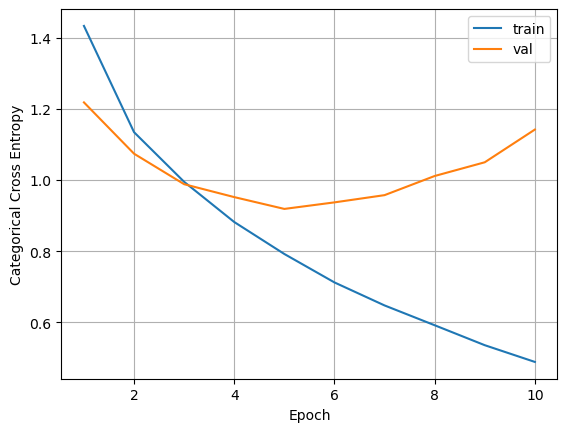

In [17]:
plt.plot(range(1, 11), model.history.history['loss'], label='train')
plt.plot(range(1, 11), model.history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Categorical Cross Entropy')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def as_input(string):
    return pad_sequences(np.array([[word2idx[w] for w in TreebankWordTokenizer().tokenize(string.lower())]]), max_words)

In [ ]:
model.predict(as_input('This food is so bad'))

1/1 [==============================] - 0s 51ms/step


array([[0.26884702, 0.19408835, 0.18528415, 0.16085261, 0.1909278 ]],
      dtype=float32)

In [ ]:
model.predict(as_input('This food is so good'))

1/1 [==============================] - 0s 57ms/step


array([[0.12348532, 0.13143587, 0.15475208, 0.25321314, 0.33711362]],
      dtype=float32)

In [ ]:
model.predict(as_input('One of the worst places Ive been, unfortunately! Rude staff, horrible service and tasteless food and coffee. Would never come back or recommend this place.'))

1/1 [==============================] - 0s 48ms/step


array([[9.0595245e-01, 8.9305595e-02, 4.4571133e-03, 9.4432340e-05,
        1.9043012e-04]], dtype=float32)